# Star Finding & Photometry with photutils


The full instructions are here:
https://photutils.readthedocs.io/en/stable/getting_started.html

If you haven't installed photutils, `%pip install photutils`

### Sophie Clark

In [8]:
cd data_mar8_2021/

[WinError 2] The system cannot find the file specified: 'data_mar8_2021/'
C:\Users\sophi\AST3722C\data_mar8_2021\data_mar8_2021


In [9]:
#pip install photutils

In [10]:
from astropy.io import fits
import photutils

In [11]:
from photutils.detection import DAOStarFinder

In [12]:
%matplotlib inline
import pylab as pl
import numpy as np
pl.style.use('dark_background')

In [13]:
fitsfile = fits.open('pleiades_30s_C_other_001_darksub_flattened.fits')
efitsfile = fits.open('pleiades_30s_C_other_001_darksub_flattened_uncertainty.fits')

First step: you need to know the PSF size!

Use what you learned in the 'measuring star properties' notebook

In [14]:
# load the image
image = fitsfile[0].data

In [15]:
# it is not background-subtracted yet, so we'll estimate and remove the background:
background = np.median(image)
background

1034.4351460591993

In [16]:
image_bgsub = image - background

In [17]:
cx,cy = 205,101
star_cutout = image_bgsub[cy-10:cy+10, cx-10:cx+10]

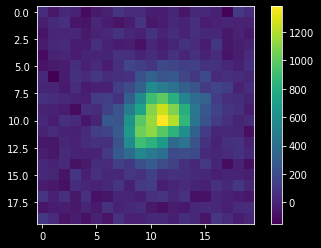

In [18]:
pl.imshow(star_cutout); _=pl.colorbar()

In [19]:
yc, xc = np.indices(star_cutout.shape)
mom1_x = (xc * star_cutout).sum() / star_cutout.sum()
mom1_y = (yc * star_cutout).sum() / star_cutout.sum()
mom2_x = ((xc - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
mom2_y = ((yc - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
sigma_to_fwhm = np.sqrt(8*np.log(2))
fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
avg_fwhm = (fwhm_x*fwhm_y)**0.5
print(f"FWHM average, in pixels: {avg_fwhm}")

FWHM average, in pixels: 5.205165654896012


In [20]:
# estimate the background noise
from astropy.stats import mad_std
background_stddev = mad_std(image_bgsub)
background_stddev

47.30047434734302

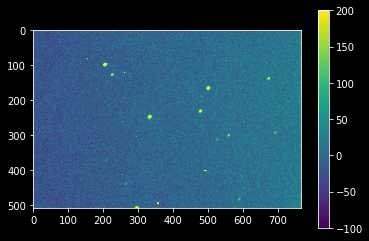

In [21]:
pl.imshow(image_bgsub, vmax=200, vmin=-100); _=pl.colorbar()

In [22]:
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=3.*background_stddev)  
sources = daofind(image_bgsub)

In [23]:
sources.show_in_notebook()

idx,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,6.512996585795222,4.5940980585320395,0.2820167538022782,-0.41730130300125234,0.4216142681529447,49,0.0,17.643282648858985,1.0252110284280413,-0.02703317335445525
1,2,232.1565875073404,5.658227290228852,0.3215535881180659,0.29010080295756624,0.9879621852498771,49,0.0,50.425099823375376,1.0424881642124002,-0.04517783238445679
2,3,78.27519187589982,6.261695311450205,0.7445720664686559,0.676812208447476,-0.12992743111181917,49,0.0,76.06255804075931,1.01252149805534,-0.013510632525871797
3,4,374.1362550452653,9.699391068794126,0.6897255287837445,-0.7710450913675978,-0.27406756530668763,49,0.0,89.01772857238257,1.051373414764802,-0.05439247791364317
4,5,143.9888420669382,15.881792217670041,0.6878721435127699,0.8854909913280641,0.1788382905132438,49,0.0,91.64479967423017,1.2159033352210884,-0.2122476243303112
5,6,667.0754160419939,22.698402993960237,0.826800743480269,-0.8566886335120117,0.23132220662011638,49,0.0,119.09957198351367,1.080486070874779,-0.08404793133085808
6,7,732.185663028405,23.04310478737822,0.30775792941885743,0.5276790413526797,0.24390761426118332,49,0.0,47.20219476728744,1.1368165876852274,-0.13922600476775387
7,8,435.9274410588519,28.451139001411295,0.7318339134400403,-0.8786671425293331,-0.7018420559938648,49,0.0,92.7933717782953,1.0136370600026994,-0.014706201463425154
8,9,100.04213384232918,31.002687826015183,0.5536697074326756,0.11431349086059699,0.04803229144027701,49,0.0,51.5322432146063,1.1129698687651979,-0.11620851729197956
9,10,162.25847168016537,32.47047875187222,0.5206333859646132,-0.23346812366671446,-0.0792483593966716,49,0.0,56.587690770053314,1.0536899839819234,-0.056782129538091364


In [24]:
from photutils.aperture import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=avg_fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,6.5129966,4.5940981,-983.85837
2,232.15659,5.6582273,880.94612
3,78.275192,6.2616953,-1069.4228
4,374.13626,9.6993911,246.59734
5,143.98884,15.881792,-800.77301
6,667.07542,22.698403,1447.5296
7,732.18566,23.043105,1460.3352
8,435.92744,28.451139,747.34463


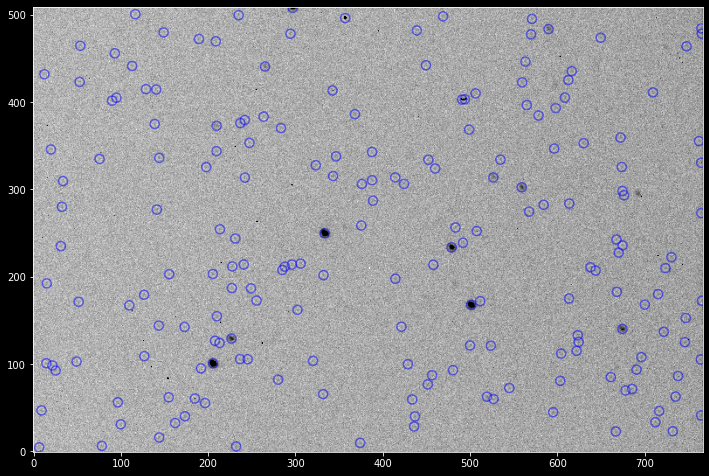

In [25]:
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-200)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)

That was _way_ too aggressive!  Let's try a higher threshold:

In [26]:
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=6.*background_stddev)  
sources = daofind(image_bgsub)

In [27]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=avg_fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,205.62452,100.79501,38170.46
2,226.71968,129.19057,10081.012
3,674.56794,140.15838,11614.489
4,501.27849,167.84401,32891.715
5,478.97722,233.65154,18359.055
6,333.51779,249.79111,38676.986
7,559.21894,302.53448,8130.3857
8,490.88919,402.88006,7489.0726


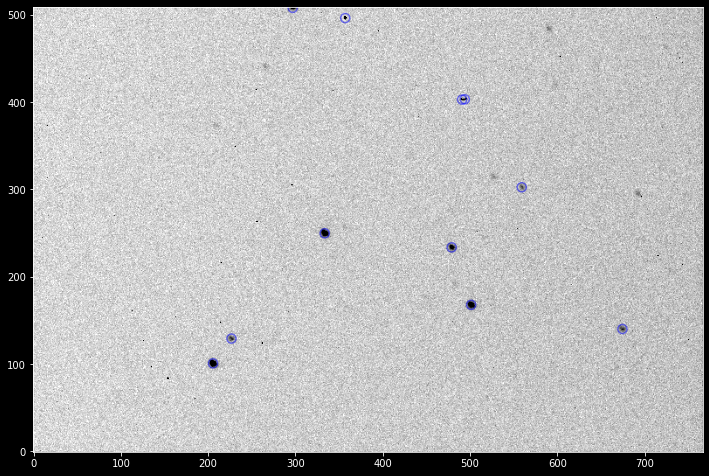

In [28]:
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-100)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)

Not aggressive enough!  Let's keep tuning...

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,184.89571,60.513785,-545.16299
2,154.93314,61.932481,-1215.9783
3,519.4154,62.547918,1288.2592
4,280.17026,82.112555,225.33916
5,205.62452,100.79501,38170.46
6,226.71968,129.19057,10081.012
7,674.56794,140.15838,11614.489
8,501.27849,167.84401,32891.715


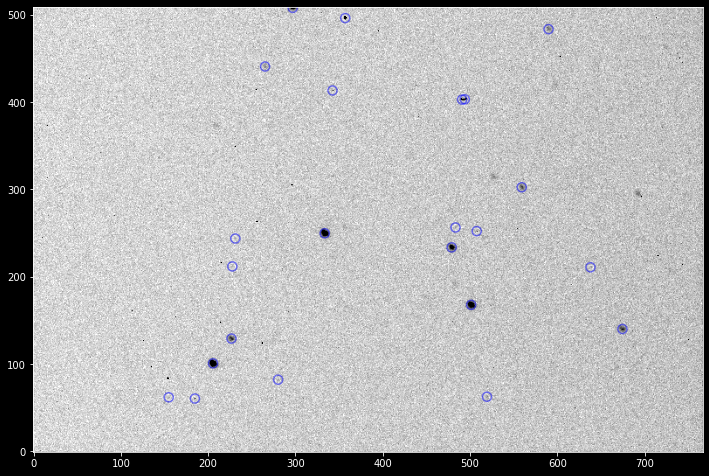

In [29]:
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=4.*background_stddev)  
sources = daofind(image_bgsub)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=avg_fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-100)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)
phot_table

This still picks up some false stars and misses some real ones.

It may be that we under-estimated the FWHM, and some stars are more smeared out than others, so we can try adjusting the FWHM:

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,764.56192,41.295608,3798.7436
2,668.04576,96.217106,3397.6375
3,205.64139,100.82853,41693.348
4,226.52018,129.31529,10618.646
5,674.48726,140.25214,13642.942
6,214.21249,147.90351,-265.59784
7,113.16558,161.3594,-2045.7403
8,501.25289,167.85194,37094.892


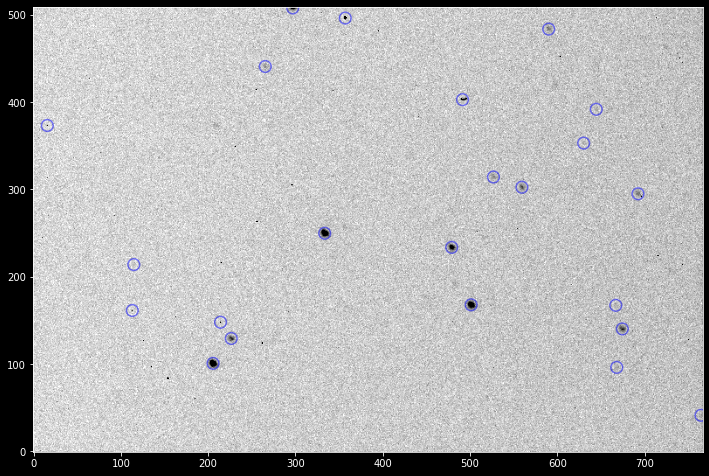

In [30]:
fwhm = 6.7
daofind = DAOStarFinder(fwhm=fwhm, threshold=4.*background_stddev)  
sources = daofind(image_bgsub)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-100)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)
phot_table

Now it looks like we got everything, and _most_ of the sources are real.  There are still some hot pixels we'd rather exclude - this is why it's important to do good alignment and median combination first!

# Error Estimation

https://photutils.readthedocs.io/en/stable/aperture.html#error-estimation

In [31]:
e_phot_table = aperture_photometry(efitsfile[0].data**2, apertures)
phot_table.add_column(e_phot_table['aperture_sum']**0.5, name='aperture_sum_uncertainty')
phot_table

id,xcenter,ycenter,aperture_sum,aperture_sum_uncertainty
,pix,pix,,
int32,float64,float64,float64,float64
1,764.56192,41.295608,3798.7436,407.89854016297676
2,668.04576,96.217106,3397.6375,494.755636014125
3,205.64139,100.82853,41693.348,530.8986299396488
4,226.52018,129.31529,10618.646,500.08082802706383
5,674.48726,140.25214,13642.942,506.80486760280803
6,214.21249,147.90351,-265.59784,490.6564401786944
7,113.16558,161.3594,-2045.7403,487.7816345998436
8,501.25289,167.85194,37094.892,529.00880175114


In [32]:
phot_table = aperture_photometry(image_bgsub, apertures, error=efitsfile[0].data)
phot_table

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int32,float64,float64,float64,float64
1,764.56192203779,41.29560782051344,3798.743577970834,407.89854016297676
2,668.0457553471205,96.21710606853718,3397.6374584014793,494.755636014125
3,205.641394677659,100.8285253189976,41693.348137228546,530.8986299396488
4,226.5201786015808,129.3152942765515,10618.646448153222,500.08082802706383
5,674.4872615281635,140.25213667750452,13642.942462421073,506.80486760280803
6,214.21248586732105,147.90351170464942,-265.5978369701926,490.6564401786944
7,113.1655786554732,161.35939783009948,-2045.7403478778135,487.7816345998436
8,501.25289231902514,167.85193584833277,37094.89248053514,529.00880175114
